# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='assets/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!generate new images!

In [9]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [7]:
from torchvision import datasets
import torchvision.transforms as T

# number of subproccesses to use for data loading
num_workers = 0 # all
# how many samples per batch to load
batch_size = 64

# Convert data to torch.FloatTensor()
transform = T.ToTensor()

# Get the training datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform, )

# Prepare the dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

 ... (more hidden) ...


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



 ... (more hidden) ...

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



 ... (more hidden) ...


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



 ... (more hidden) ...

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



## Visualize the data

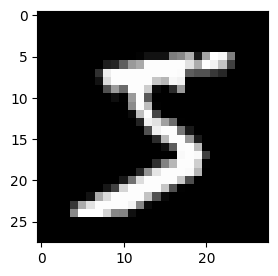

In [10]:
# Obtain one batch of training images
dataiter = iter(train_data)
images, labels = next(dataiter)
images = images.numpy()

# Get one image
img = np.squeeze(images[0])

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [16]:
images[0].shape

(28, 28)

---
## Define the Model
A GAN is comprised of two adversarial networks, a discriminator and a generator

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='assets/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='assets/leaky_relu.png' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.



In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    """
    Discriminator Model:
    args:
    - input_dim : dimension of the input data. For a 28 * 28 grayscale image, the input size is 784
    - hidden_dim: a parameter that controls the dimension of the hidden layers.
    """

    def __init__(self, input_size: int, hidden_dim: int):
        super(Discriminator, self).__init__()

        # Define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)

        # Final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim // 4, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Define the activation
        self.activation = nn.LeakyReLU(0.2)

        # Flattem layer
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten image
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)

        # BCE with logits loss will be applied
        x = self.fc4(x)
        return x

### hyperparameters

In [27]:
input_dim = 784
hidden_dim = 256

discriminator = Discriminator(input_dim, hidden_dim)

## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='assets/tanh_fn.png' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

I'll do this in the training loop, later on.

In [28]:
class Generator(nn.Module):

    def __init__(self, latent_dim: int, hidden_dim: int, output_size: int):
        super(Generator, self).__init__()

        # Define hidden linear layers
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        # Final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim * 4, output_size)

        # Define the activation
        self.activation = nn.LeakyReLU(0.2)
        self.final_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)

        x = self.fc4(x)
        x = self.final_activation(x)
        return x

In [29]:
latent_dim = 128
hidden_dim = 256
output_dim = 784

generator = Generator(latent_dim, hidden_dim, output_dim)

---
## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='assets/gan_pipeline.png' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 


In [30]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # Label smoothing
    if smooth:
        # Smooth, real labels = 0.9
        labels = torch.ones_like(D_out) * 0.9
    else: 
        labels = torch.ones_like(D_out) # real labels = 1
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, labels)
    return loss


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [31]:
def fake_loss(D_out):
    labels = torch.zeros_like(D_out) # Fake labels = 0
    criterion = nn.BCEWithLogitsLoss(D_out, labels)
    # Calculate loss
    loss = criterion(D_out, labels)
    return loss